### Import custom modules from current folder

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import nltk
from sklearn.model_selection import train_test_split
# from simple_text_representation.classes import Text
# from simple_text_representation.models import Database
import pandas as pd
import numpy as np
# from nltk.draw.tree import draw_trees

In [62]:
print(__doc__)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM
from keras.optimizers import Adam

import itertools

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(7)

Automatically created module for IPython interactive environment


In [3]:
# database = Database('educationalTexts', 'postgres', '', '0.0.0.0', 5432)
# path = r'http://localhost/'

In [4]:
def transformToString(text):
    textStr = ''

    for paragraph in text:
        for line in paragraph:
            textStr = textStr + line
    return textStr

### Load the data

In [5]:
dfSeventh = pd.read_csv('../Data/textsSeventhgrade.csv')
dfEighth = pd.read_csv('../Data/textsEighthgrade.csv')
dfNinth = pd.read_csv('../Data/textsNinthgrade.csv')
dfTenth = pd.read_csv('../Data/textsTenthGrade.csv')
dfEleventh = pd.read_csv('../Data/textsEleventhgrade.csv')

### Transform the data to known structures

In [6]:
def transform_csv_to_structure(df):
    text_ids = df['id'].unique()
    texts = list()
    for text_id in text_ids:
        sentence_grouped = df.where(dfSeventh['id'] == 1)
        clean_df = df[pd.notnull(sentence_grouped['id'])]
        paragraphs = list()
        df_paragraphs = clean_df.groupby('paragraph_id').apply(lambda x: "%s" % '|'.join(x['value'])).values
        for df_paragraph in df_paragraphs:
            paragraphs.append(df_paragraph.split('|'))
        texts.append(paragraphs)

    return texts

In [7]:
textOfSeventhGrade = transform_csv_to_structure(dfSeventh)
textOfEightGrade = transform_csv_to_structure(dfEighth)
textOfNineGrade = transform_csv_to_structure(dfNinth)
textOfTenthGrade = transform_csv_to_structure(dfTenth)
textOfEleventhGrade = transform_csv_to_structure(dfEleventh)

textsFormatedSG = [transformToString(textArr) for textArr in textOfSeventhGrade]
textsFormatedEG = [transformToString(textArr) for textArr in textOfEightGrade]
textsFormatedNG = [transformToString(textArr) for textArr in textOfNineGrade]
textsFormatedTG = [transformToString(textArr) for textArr in textOfTenthGrade]
textsFormatedEG = [transformToString(textArr) for textArr in textOfEleventhGrade]

### Format train and test data

In [8]:
data = np.concatenate((np.array(textsFormatedSG),
                       np.array(textsFormatedEG),
                       np.array(textsFormatedNG),
                       np.array(textsFormatedTG),
                       np.array(textsFormatedEG)  )) 
labels = np.concatenate((np.full(len(textsFormatedSG), 0),
                         np.full(len(textsFormatedEG), 1),
                         np.full(len(textsFormatedNG), 2),
                         np.full(len(textsFormatedTG), 3),
                         np.full(len(textsFormatedEG), 4)))

In [9]:
len(data)

179

In [10]:
len(labels)

179

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
len(y_train)

143

In [13]:
len(x_train)

143

### Load the trained embeddings

In [14]:
EMBEDDINGS_DIMESION = 300

In [15]:
embeddingsIndex = dict()
f = open('../SBW-vectors-300-min5.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddingsIndex[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddingsIndex))

Loaded 1000654 word vectors.


### Preprocesing the data

In [16]:
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
from math import ceil

# from torch.nn.utils.rnn import pad_sequence
# import spacy
torch.__version__

/home/jchu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'0.4.0'

In [17]:
# nlp = spacy.load('es')
# doc = nlp(textOfSeventhGrade[0][0][0])
# token_sentence = [token for token in doc]
# # token_sentence

In [18]:
def createEmbedingMatrix(tokenizer, vocabSize):
    embeddingMatrix = np.zeros((vocabSize, 300))
    for word, i in tokenizer.word_index.items():
        embeddingVector = embeddingsIndex.get(word)
        if embeddingVector is not None:
            embeddingMatrix[i] = embeddingVector
    return embeddingMatrix

In [19]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    vocabSize = len(tokenizer.word_index) + 1
    encodedData = tokenizer.texts_to_sequences(x)
    maxLength = EMBEDDINGS_DIMESION
    paddedData = pad_sequences(encodedData, maxlen=maxLength, padding='post')
    embeddings = createEmbedingMatrix(tokenizer, vocabSize)
    
    return paddedData

In [20]:
def createTrainData(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    vocabSize = len(tokenizer.word_index) + 1
    encodedData = tokenizer.texts_to_sequences(x)
    maxLength = EMBEDDINGS_DIMESION
    paddedData = pad_sequences(encodedData, maxlen=maxLength, padding='post')
    embeddings = createEmbedingMatrix(tokenizer, vocabSize)
    
    return paddedData, embeddings, maxLength, vocabSize

In [61]:
x_train_tokenize, x_train_embeddings, x_train_max_features, x_train_vocab_size  = createTrainData(x_train)
x_test_tokenize = tokenize(x_test)


torch_train_embeddings = torch.from_numpy(x_train_embeddings)
torch_train_tokenize = torch.from_numpy(x_train_tokenize)
torch_test_tokenize = torch.from_numpy(x_test_tokenize)

torch_train_tokenize = torch_train_tokenize.type(torch.cuda.LongTensor)
torch_train_embeddings = torch_train_embeddings.type(torch.cuda.FloatTensor)
torch_test_tokenize = torch_test_tokenize.type(torch.cuda.LongTensor)

torch_train_tokenize.req_grad = True

torch_train_tokenize.cuda()
torch_train_embeddings.cuda()
torch_test_tokenize.cuda()

# torch_train_embeddings
# torch_train_tokenize
torch_train_tokenize.shape
torch_train_embeddings.shape
torch_test_tokenize.shape

torch.Size([36, 300])

### Creating the model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [25]:
# embed = torch.ones([300, 1, 500])

In [26]:
# embed.shape

In [27]:
# m = torch.ones([300, 1, 5])

In [28]:
# d = [1, 2, 3, 4, 5]

In [29]:
# "A B C D E" -> 12 13 45 23 12 -> [1.2, 2.3] [1.3, 4.3] [0.2, 2.3] [1.2, 2.3] [1.2, 2.3] 
#                               -> [d, d, d, d, d]

In [30]:
# torch.cat((embed, m), dim=2)

In [31]:
# m.shape

In [32]:
# len(torch.chunk(embed, chunks=300))

In [33]:
# d = torch.chunk(embed, chunks=300)

In [34]:
# for v in d:
#     torch.cat((embed, m),)

In [35]:
# torch.cat((embed, m), dim=2)

In [25]:
def create_weight_matrix(dict_embeddings):
    matrix_len = len(dict_embeddings)
    weights_matrix_emb = np.zeros((matrix_len, EMBEDDINGS_DIMESION))
    
    for i, word in enumerate(dict_embeddings):
        weights_matrix_emb[i] = dict_embeddings[word]
        
    return  weights_matrix_emb

In [26]:
def create_emb_layer(emb_matrix, non_trainable=False):
    num_embeddings, embedding_dim = emb_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.weight = nn.Parameter(emb_matrix)
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [60]:
class LSTMClassifier(nn.Module):

    def __init__(self, weights_matrix, hidden_dim, vocab_size, batch_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.tagset_size = tagset_size

        num_embeddings, embedding_dim = weights_matrix.shape
        self.embedding_dim = embedding_dim
        self.word_embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.word_embeddings.weight.data.copy_(weights_matrix)
        self.word_embeddings.weight.requires_grad = False

#         self.word_embeddings, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, 1)

        # The linear layer that maps from hidden state space to tag space
        # + 5 in the hidden_dim after the LSTM
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden(batch_size)

    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, batch_size, self.hidden_dim).cuda(),
                torch.zeros(1, batch_size, self.hidden_dim).cuda())
    
    def change_hidden(self, new_batch_size):
        self.batch_size = new_batch_size
        self.hidden = (torch.zeros(1, new_batch_size, self.hidden_dim).cuda(),
                    torch.zeros(1, new_batch_size, self.hidden_dim).cuda())

    # Recibe el batch
    # [[1,2,3,4,5,6]] [[0.4,14,5123,123,21]]
    # [[]]
    def forward(self, text):
        embeds = self.word_embeddings(text) # batch de textos
        # Append de las metricas al batch ( con cat )
        # torch.cat((embeds, metrics), 2)
        # (seq_len, batch_size, embed_size)
        embeds.requires_grad = True
#         print(len(embeds), self.batch_size, len(embeds) < self.batch_size)
        if (len(embeds) != self.batch_size):
            self.change_hidden(len(embeds))           
        
#         print('Embeds', embeds.shape);
#         print('Embeds', embeds.view(self.embedding_dim, self.batch_size, -1).shape);
#         print('Hidden Size:', self.hidden[0].shape)
        lstm_out, self.hidden = self.lstm(embeds.view(self.embedding_dim, self.batch_size, -1), self.hidden)

#         print('LSTM out:', lstm_out.shape)
#         lstm_out = lstm_out.view(self.batch_size, self.embedding_dim, -1)
        
#         print('Last LSTM out:' , lstm_out[-1].shape)
        tag_space = self.hidden2tag(lstm_out[-1])

#         print('Tags calculated:', tag_space.shape)
        tag_scores = F.log_softmax(tag_space, dim=1)
#         print('Log softmax:', tag_scores.shape)
        tag_scores = tag_scores.view(-1, self.tagset_size)
        return tag_scores

### Training the model

In [28]:
#batch_size - num_hidden_neurons - epochs - embedding_size - precision
testParams2 = [
  [32, 64, 10],
  [32, 128, 10],
  [32, 64, 20],
  [32, 128, 20],
  [32, 256, 20],
  [32, 64, 30],
  [32, 128, 30],
  [32, 64, 40],
  [32, 128, 40],
  [64, 64, 40],
  [64, 128, 40],
  [64, 256, 40],
  [32, 64, 50],
]

#### Transform dictionary into matrix

In [29]:
# final_weigth_matrix = torch.from_numpy(create_weight_matrix(embeddingsIndex))

In [30]:
# final_weigth_matrix = final_weigth_matrix.type(torch.FloatTensor)
# final_weigth_matrix.shape

In [31]:
def split_train_batchs(arr_tokens, arr_targets, batch_size):
    max_length = ceil(len(arr_tokens)/batch_size)
    torch_train_batchs = list()
    y_train_batchs = list()

    for i in range(max_length):
        torch_train_batch = arr_tokens[i*batch_size:(i+1)*batch_size]
        y_train_batch = arr_targets[i*batch_size:(i+1)*batch_size]
        torch_train_batchs.append(torch_train_batch)
        y_train_batchs.append(y_train_batch)

    data_train_batch = list(zip(torch_train_batchs, y_train_batchs))

    return data_train_batch

In [69]:
def testModel(hidden_dim, epochs, texts_batch_size, train_batchs):
    model = LSTMClassifier(torch_train_embeddings, hidden_dim, x_train_vocab_size, texts_batch_size, 5).cuda()
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)
    
    # Training the model
    for epoch in range(epochs):
        for index, (batch_text, targets) in enumerate(train_texts_batchs):
            print('\nEpoch :', epoch, 'Batch: ', index)
            # We need to clear the gradients before each instance
            model.zero_grad()

            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            model.hidden = model.init_hidden(texts_batch_size)

            # Run our forward pass.
            tag_scores = model(batch_text)
            torch_targets = torch.from_numpy(targets)
            torch_targets = torch_targets.type(torch.cuda.LongTensor)
            # Compute the loss, gradients, and update the parameters by calling optimizer.step()
#             print('Tags predicted: ', tag_scores)
            loss = loss_function(tag_scores, torch_targets)
            print('Loss results\n', loss)
            loss.backward()
            optimizer.step()

    # Test the model
    with torch.no_grad():
        # Test input => torch_test_tokenize
        test_tag_scores = model(torch_test_tokenize)
        y = torch.argmax(test_tag_scores, dim=1)
        print(y)
        # Metrics calculation
        f1_result_score = f1_score(y_test, y, average='macro')
        precision_result_score = precision_score(y_test, y, average='macro')
        recall_result_score = recall_score(y_test, y, average='macro')
        accuracy_result_score = accuracy_score(y_test, y)
        
        return y, [f1_result_score, precision_result_score, recall_result_score, accuracy_result_score]

In [70]:
model_predictios_results = list()
model_metrics_results = list()

for param_batch_size, num_hidden_neurons, epochs in testParams2:
    train_texts_batchs = split_train_batchs(torch_train_tokenize, y_train, param_batch_size) # tokens -> num_text/batch_size x batch_size x 300
#     print('Hidden layer:', num_hidden_neurons)
#     print('Epochs:', epochs)
#     print('Batch size:', param_batch_size)
    prediction, model_metrics = testModel(num_hidden_neurons, epochs, param_batch_size, train_texts_batchs)
    model_predictios_results.append(prediction)
    model_metrics_results.append(model_metrics)


Epoch : 0 Batch:  0
Loss results
 tensor(1.6065, device='cuda:0')

Epoch : 0 Batch:  1
Loss results
 tensor(3.7061, device='cuda:0')

Epoch : 0 Batch:  2
Loss results
 tensor(1.6946, device='cuda:0')

Epoch : 0 Batch:  3
Loss results
 tensor(1.6581, device='cuda:0')

Epoch : 0 Batch:  4
Loss results
 tensor(1.5741, device='cuda:0')

Epoch : 1 Batch:  0
Loss results
 tensor(1.6896, device='cuda:0')

Epoch : 1 Batch:  1
Loss results
 tensor(3.7048, device='cuda:0')

Epoch : 1 Batch:  2
Loss results
 tensor(1.8999, device='cuda:0')

Epoch : 1 Batch:  3
Loss results
 tensor(1.8161, device='cuda:0')

Epoch : 1 Batch:  4
Loss results
 tensor(2.1807, device='cuda:0')

Epoch : 2 Batch:  0
Loss results
 tensor(1.7130, device='cuda:0')

Epoch : 2 Batch:  1
Loss results
 tensor(1.6134, device='cuda:0')

Epoch : 2 Batch:  2
Loss results
 tensor(1.6374, device='cuda:0')

Epoch : 2 Batch:  3
Loss results
 tensor(1.8575, device='cuda:0')

Epoch : 2 Batch:  4
Loss results
 tensor(1.6953, device='cuda

/home/jchu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jchu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch : 0 Batch:  0
Loss results
 tensor(1.6130, device='cuda:0')

Epoch : 0 Batch:  1
Loss results
 tensor(6.0287, device='cuda:0')

Epoch : 0 Batch:  2
Loss results
 tensor(2.3396, device='cuda:0')

Epoch : 0 Batch:  3
Loss results
 tensor(6.2502, device='cuda:0')

Epoch : 0 Batch:  4
Loss results
 tensor(5.8073, device='cuda:0')

Epoch : 1 Batch:  0
Loss results
 tensor(5.1220, device='cuda:0')

Epoch : 1 Batch:  1
Loss results
 tensor(4.3769, device='cuda:0')

Epoch : 1 Batch:  2
Loss results
 tensor(3.7598, device='cuda:0')

Epoch : 1 Batch:  3
Loss results
 tensor(3.4962, device='cuda:0')

Epoch : 1 Batch:  4
Loss results
 tensor(2.4931, device='cuda:0')

Epoch : 2 Batch:  0
Loss results
 tensor(2.8531, device='cuda:0')

Epoch : 2 Batch:  1
Loss results
 tensor(4.1639, device='cuda:0')

Epoch : 2 Batch:  2
Loss results
 tensor(3.6730, device='cuda:0')

Epoch : 2 Batch:  3
Loss results
 tensor(3.2677, device='cuda:0')

Epoch : 2 Batch:  4
Loss results
 tensor(2.5412, device='cuda

### Plot the results

In [81]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
CLASSES = ["Seventh Grade", "Eighth Grade", "Ninth grade", "Tenth grade", "Eleven grade"]

In [114]:
def array_to_percentage(result_arr):
    return ["{0:.2f}%".format(item*100) for item in result_arr]

In [115]:
def transform_metrics_results_to_percentage(results):
    np_results = np.array(results)
    np_results = [array_to_percentage(model_results) for model_results in np_results]
    
    return np_results

In [116]:
results_columns = ["F1 Score", "Precision Score", "Recall Score", "Accuracy Score"]
pd.DataFrame(transform_metrics_results_to_percentage(model_metrics_results), columns=results_columns)

,F1 Score,Precision Score,Recall Score,Accuracy Score
0,15.02%,12.73%,25.00%,30.56%
1,18.51%,18.65%,18.86%,25.00%
2,12.46%,13.98%,18.00%,13.89%
3,15.23%,13.19%,18.71%,16.67%
4,11.56%,12.65%,13.00%,13.89%
5,21.92%,24.57%,26.57%,25.00%
6,6.51%,3.89%,20.00%,19.44%
7,12.82%,9.09%,28.57%,19.44%
8,19.56%,16.41%,25.71%,25.00%
9,10.00%,14.61%,15.00%,11.11%


In [78]:
confusionMatrixs = list()

for prediction in model_predictios_results:
    confusionMatrix = confusion_matrix(y_test, prediction)
    np.set_printoptions(precision=2)
    confusionMatrixs.append(confusionMatrix)

Confusion matrix, without normalization
[[10  0  0  0  0]
 [ 5  0  0  0  2]
 [ 5  0  0  0  0]
 [10  0  0  0  0]
 [ 3  0  0  0  1]]


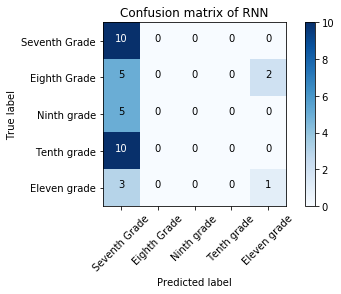

In [82]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[0], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[4 2 0 2 2]
 [2 1 0 1 3]
 [2 3 0 0 0]
 [3 1 0 4 2]
 [2 1 0 1 0]]


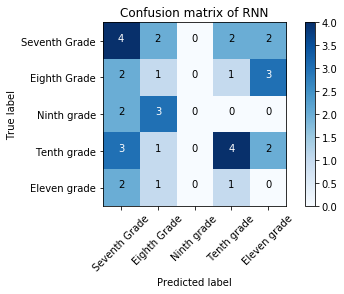

In [83]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[1], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[2 0 0 0 8]
 [3 0 0 0 4]
 [0 0 1 0 4]
 [1 1 1 0 7]
 [1 0 1 0 2]]


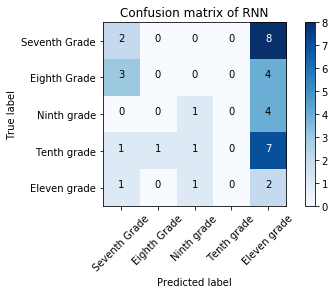

In [84]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[2], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[2 4 1 0 3]
 [3 2 1 0 1]
 [1 2 1 0 1]
 [4 1 2 0 3]
 [1 1 1 0 1]]


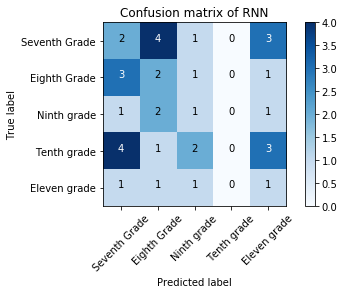

In [85]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[3], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[2 1 2 1 4]
 [3 0 1 1 2]
 [0 1 0 3 1]
 [1 2 0 2 5]
 [0 0 1 2 1]]


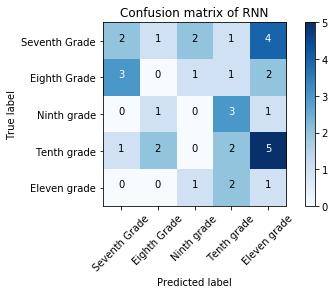

In [86]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[4], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[2 3 0 0 5]
 [1 3 0 0 3]
 [1 2 0 1 1]
 [2 2 1 2 3]
 [1 0 0 1 2]]


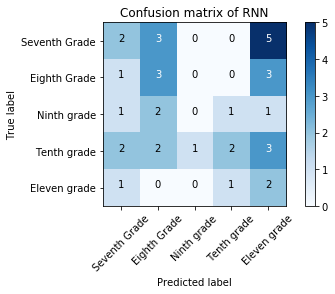

In [87]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[5], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[ 0 10  0  0  0]
 [ 0  7  0  0  0]
 [ 0  5  0  0  0]
 [ 0 10  0  0  0]
 [ 0  4  0  0  0]]


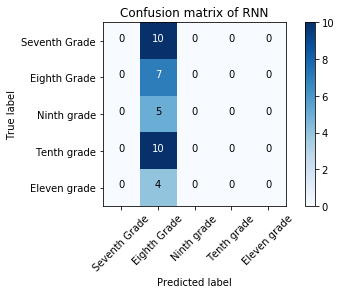

In [88]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[6], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[0 4 0 0 6]
 [1 3 0 0 3]
 [1 1 0 0 3]
 [1 3 0 0 6]
 [0 0 0 0 4]]


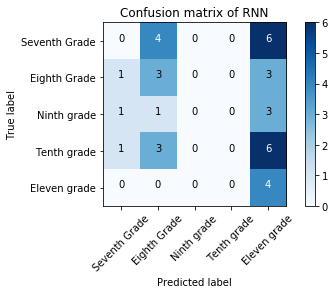

In [89]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[7], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[5 1 0 0 4]
 [3 2 0 1 1]
 [3 2 0 0 0]
 [5 2 1 0 2]
 [0 0 0 2 2]]


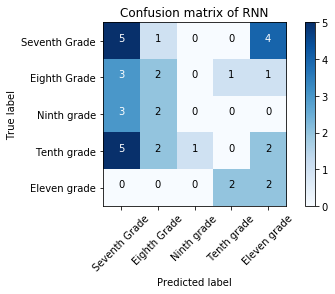

In [90]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[8], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[0 3 4 0 3]
 [0 0 6 0 1]
 [0 0 2 1 2]
 [1 2 5 1 1]
 [0 1 2 0 1]]


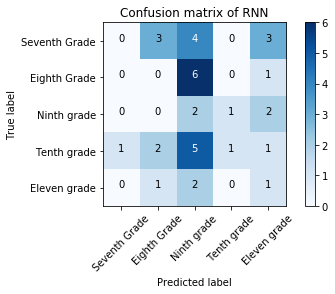

In [91]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[9], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[2 6 0 0 2]
 [3 2 0 0 2]
 [1 2 1 0 1]
 [3 5 0 0 2]
 [2 2 0 0 0]]


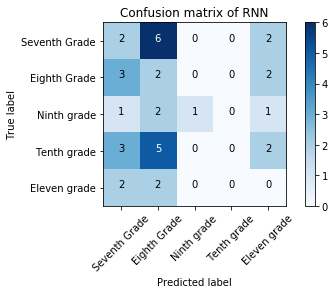

In [92]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[10], classes=CLASSES, title=plot_title)

Confusion matrix, without normalization
[[1 0 4 5 0]
 [2 1 2 2 0]
 [1 0 1 3 0]
 [2 0 2 6 0]
 [2 0 0 1 1]]


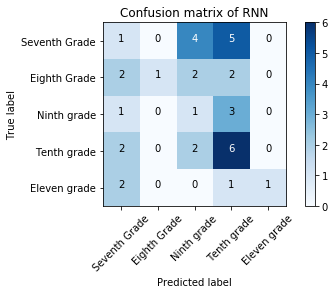

In [93]:
plot_title = 'Confusion matrix of RNN'
plt.figure()
plot_confusion_matrix(confusionMatrixs[11], classes=CLASSES, title=plot_title)